## Spatial Weights

In [70]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from pysal.model import spreg
import contextily as ctx
from libpysal.weights.util import block_weights
from esda.moran import Moran
from libpysal.weights import lag_spatial

## Load data

In [71]:
current_dir = os.getcwd()
path = os.path.join(current_dir, '../data/clean', "merged_dataset_1.csv")
df = pd.read_csv(path)

In [72]:
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:28992')

## Select year

In [73]:
df = df[df["Year"] == 2018].copy()
len(df)

54

## Spatial distribution of nitrate

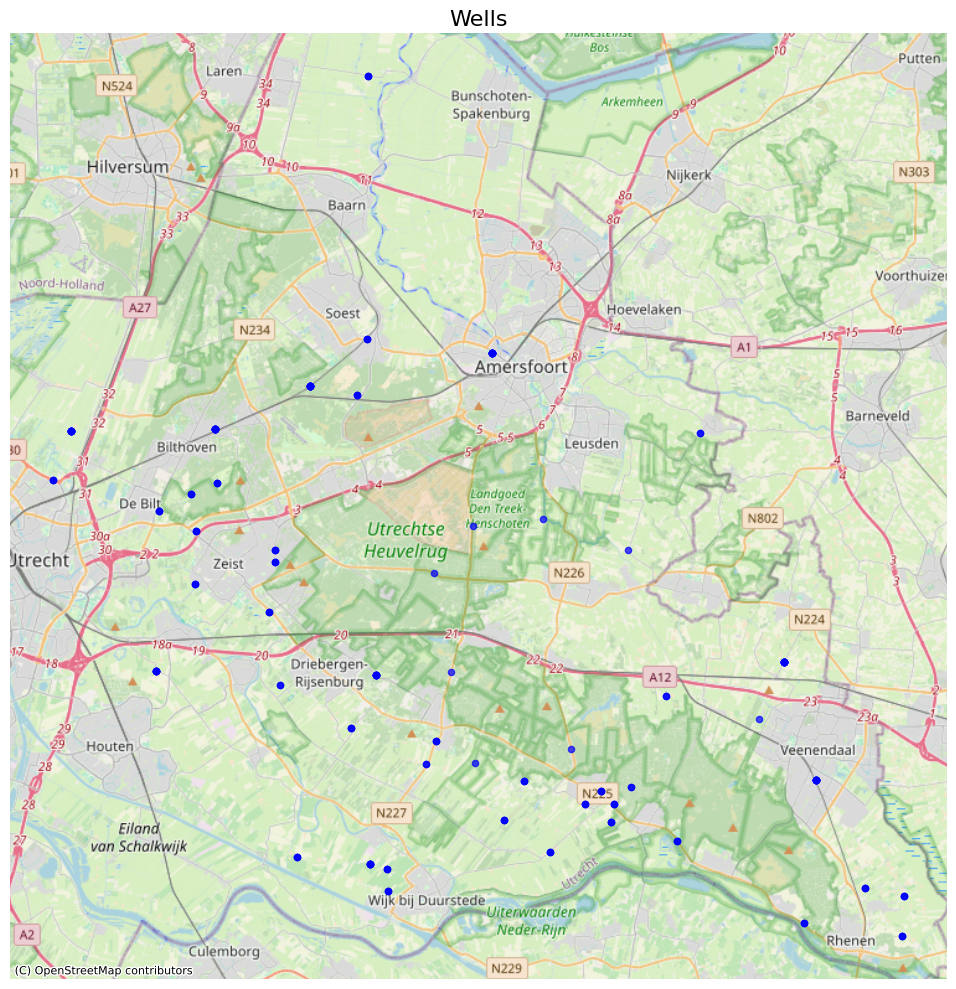

In [74]:
gdf = gdf.reset_index(drop=True)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", markersize=20, alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Wells", fontsize=16)
plt.tight_layout()
plt.show()

## Remove spatial outliner

In [75]:
gdf = gdf.drop(gdf[gdf["Well_ID"] == "GMW000000024093"].index)

## Remove nitrate outliers

In [76]:
q1 = gdf["Nitrate"].quantile(0.25)
q3 = gdf["Nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = gdf[(gdf["Nitrate"] < lower_bound) | (gdf["Nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

top_nitrate_outliers = list(gdf["Nitrate"].sort_values()[-len(outliers):].index)
top_nitrate_outliers
gdf = gdf.drop(top_nitrate_outliers)
len(gdf)

Outliers found: 7


182

In [77]:
len(gdf["Well_ID"].unique())

48

## Remove overlapping nodes (same location)

In [78]:
gdf_grouped = gdf.groupby("geometry").mean(numeric_only=True).reset_index()
gdf_unique = gpd.GeoDataFrame(gdf_grouped, geometry='geometry', crs=gdf.crs)
gdf = gdf_unique.to_crs(epsg=3857)
len(gdf)

48

In [ ]:
gdf = gdf.reset_index(drop=True)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", markersize=20, alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Wells", fontsize=16)
plt.tight_layout()
plt.show()

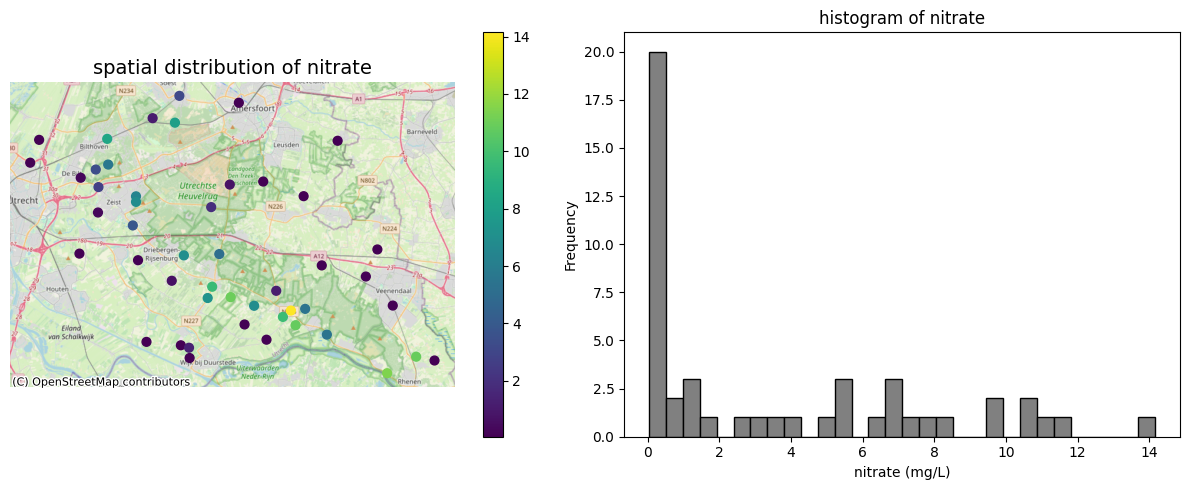

In [80]:
gdf = gdf.to_crs(epsg=3857)
f, ax = plt.subplots(1, 2, figsize=(12, 5))

# gdf.plot("Nitrate", cmap="viridis", markersize=40, ax=ax[0], legend=True)
# ax[0].set_title("Spatial Distribution of Nitrate")
# ax[0].set_axis_off()
gdf.plot("Nitrate", cmap="viridis", markersize=40, ax=ax[0], legend=True)
ctx.add_basemap(ax[0], source=ctx.providers.OpenStreetMap.Mapnik)
ax[0].set_title("spatial distribution of nitrate", fontsize=14)
ax[0].set_axis_off()

gdf["Nitrate"].plot.hist(ax=ax[1], bins=30, color="gray", edgecolor="black")
ax[1].set_title("histogram of nitrate")
ax[1].set_xlabel("nitrate (mg/L)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Kernel weights (adaptive)

In [81]:
gdf = gdf.reset_index(drop=True)
gdf = gdf.to_crs(epsg=3857)

# knn 4 nearest neighbors
w_kernel_adaptive = weights.Kernel.from_dataframe(gdf, k=4, fixed=False)

print("Kernel function:", w_kernel_adaptive.function)
print("First 5 bandwidths:", w_kernel_adaptive.bandwidth[:10])

Kernel function: triangular
First 5 bandwidths: [[8581.14746444]
 [7056.03977749]
 [8131.62441424]
 [6893.17424204]
 [5305.43409369]
 [5891.07016424]
 [3978.30019539]
 [5305.43409369]
 [5986.53383768]
 [5900.72522973]]


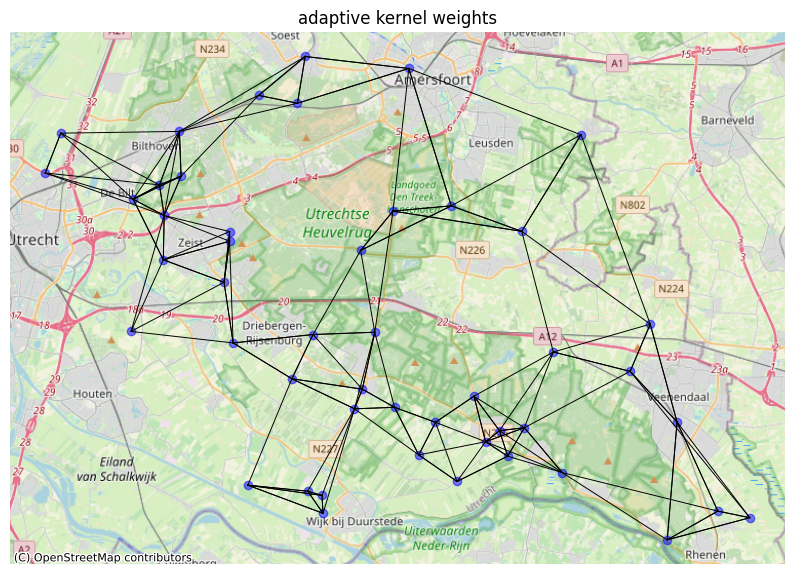

In [82]:
ax = gdf.plot(figsize=(10, 10), color='blue', alpha=0.5)

for i, neighbors in w_kernel_adaptive.neighbors.items():
    origin = gdf.geometry.iloc[i]
    for j in neighbors:
        dest = gdf.geometry.iloc[j]
        ax.plot([origin.x, dest.x], [origin.y, dest.y], color='black', linewidth=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("adaptive kernel weights")
plt.axis("off")
plt.show()

## Kernel weights (fixed)

In [83]:
gdf = gdf.to_crs(epsg=3857)

w_fixed_kernel = weights.Kernel.from_dataframe(gdf, fixed=True, function='gaussian')

print("Kernel function:", w_fixed_kernel.function)
print("Bandwidth (same for all):", w_fixed_kernel.bandwidth[0])  # since fixed, all are equal


Kernel function: gaussian
Bandwidth (same for all): [11019.62771934]


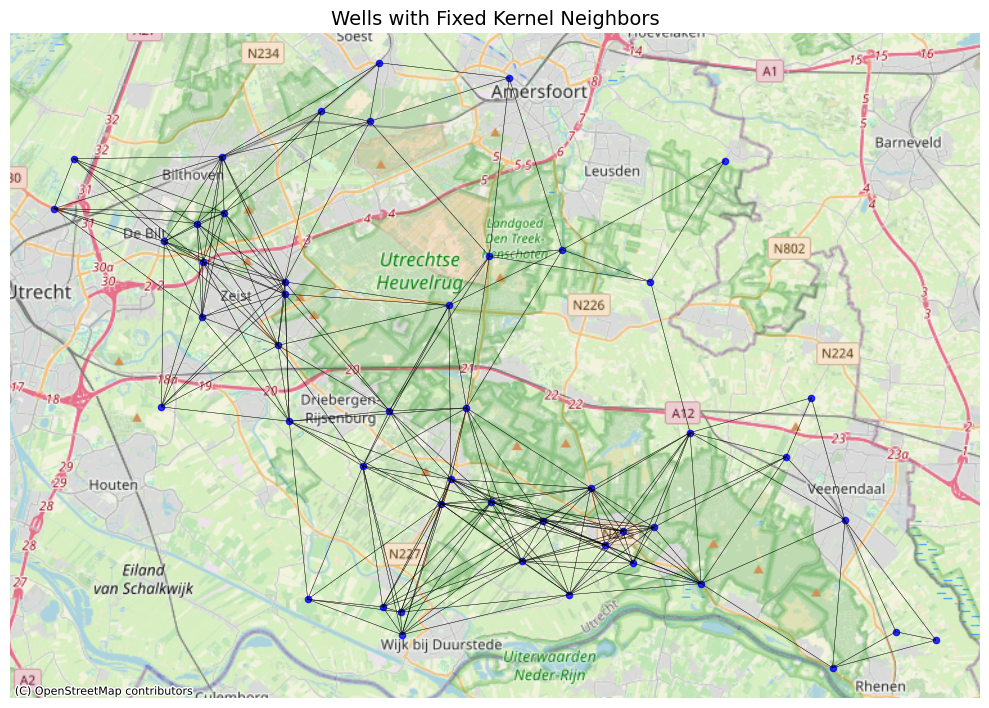

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, color='blue', markersize=20, alpha=0.8)

for i, neighbors in w_fixed_kernel.neighbors.items():
    origin = gdf.geometry.iloc[i]
    for j in neighbors:
        dest = gdf.geometry.iloc[j]
        ax.plot([origin.x, dest.x], [origin.y, dest.y], color='black', linewidth=0.3, alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Wells with Fixed Kernel Neighbors", fontsize=14)
plt.tight_layout()
plt.show()


#### What these kernels look like on the map

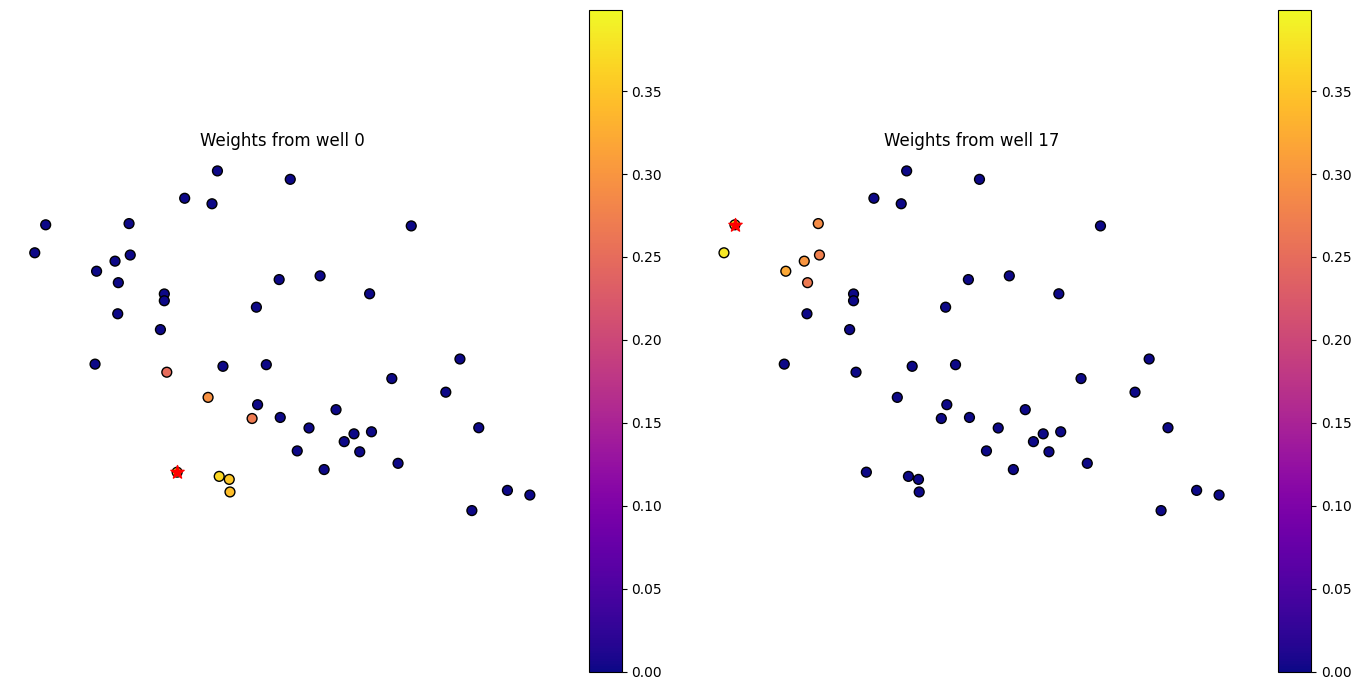

In [85]:
# full weight matrix and index order
full_matrix, ids = w_fixed_kernel.full()

gdf = gdf.reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(aspect='equal')) # plot weight intensity from two wells

gdf.assign(weight_0=full_matrix[0]).plot(
    column='weight_0', cmap='plasma', ax=ax[0],
    legend=True, markersize=50, edgecolor='black'
)
gdf.iloc[[0]].plot(ax=ax[0], color='red', marker='*', markersize=100)
ax[0].set_title("Weights from well 0")
ax[0].set_axis_off()

gdf.assign(weight_17=full_matrix[17]).plot(
    column='weight_17', cmap='plasma', ax=ax[1],
    legend=True, markersize=50, edgecolor='black'
)
gdf.iloc[[17]].plot(ax=ax[1], color='red', marker='*', markersize=100)
ax[1].set_title("Weights from well 17")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()


## Nitrate level difference between Neighbors and Non-Neighbors

In [86]:
adjlist = w_kernel_adaptive.to_adjlist()

In [87]:
adjlist_nitrate = adjlist.merge(
    gdf[["Nitrate"]], left_on="focal", right_index=True
).merge(
    gdf[["Nitrate"]], left_on="neighbor", right_index=True,
    suffixes=("_focal", "_neighbor")
)

In [88]:
adjlist_nitrate["diff"] = (
    adjlist_nitrate["Nitrate_focal"] - adjlist_nitrate["Nitrate_neighbor"]
).abs()

In [89]:
all_diffs = np.subtract.outer(gdf["Nitrate"].values, gdf["Nitrate"].values)

In [90]:
W_matrix = w_kernel_adaptive.sparse.toarray()
complement_W = 1 - W_matrix

In [91]:
non_neighbor_diffs = (complement_W * np.abs(all_diffs)).flatten()
non_neighbor_diffs = non_neighbor_diffs[non_neighbor_diffs != 0]  # remove 0s

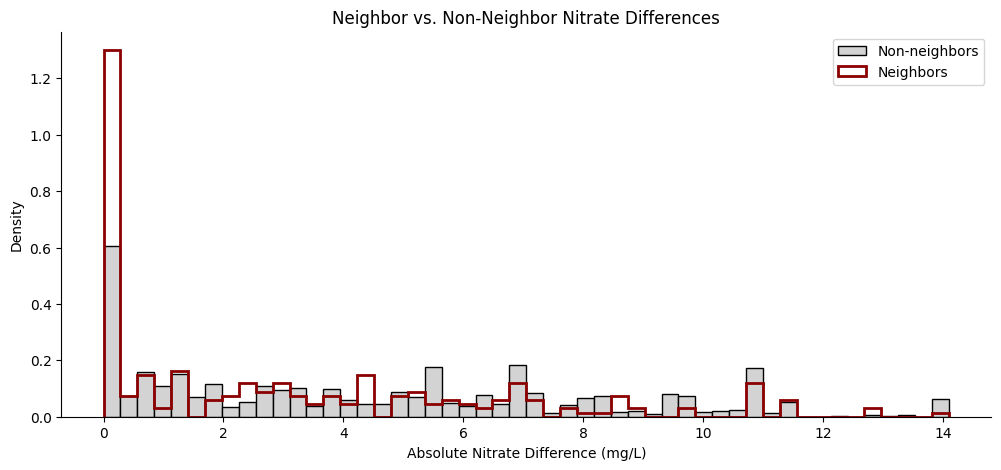

In [92]:
plt.figure(figsize=(12, 5))

plt.hist(
    non_neighbor_diffs,
    bins=50,
    density=True,
    color="lightgray",
    edgecolor="black",
    label="Non-neighbors"
)

plt.hist(
    adjlist_nitrate["diff"],
    bins=50,
    density=True,
    histtype="step",
    linewidth=2,
    color="darkred",
    label="Neighbors"
)

sns.despine()
plt.xlabel("Absolute Nitrate Difference (mg/L)")
plt.ylabel("Density")
plt.title("Neighbor vs. Non-Neighbor Nitrate Differences")
plt.legend()
plt.show()


## Assess spatial autocorrelation

In [93]:
gdf = gdf.reset_index(drop=True)
moran = Moran(gdf["Nitrate"].values, w_kernel_adaptive)

print(f"Moran's I: {moran.I:.4f}")
print(f"Expected I: {moran.EI:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

Moran's I: 0.7449
Expected I: -0.0213
p-value: 0.0020
